In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import random

#### Importing Data

In [3]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

--2022-05-02 10:05:57--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2022-05-02 10:05:57--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/x-gzip]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M   109MB/s    in 7.9s    

2022-05-02 10:06:05 (96.2 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]

--2022-05-02 10:06:05--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Co

#### Creating paths to input and target directory

In [4]:
import os

input_dir = "images/"
target_dir = "annotations/trimaps/"

input_img_paths = sorted([os.path.join(input_dir, fname) for fname in os.listdir(input_dir) if fname.endswith(".jpg")])

target_paths = sorted([os.path.join(target_dir, fname) for fname in os.listdir(target_dir) if fname.endswith(".png") and not fname.startswith(".")])

#### Let's see one of the images and it's mask

In [5]:
from tensorflow.keras.utils import load_img, img_to_array

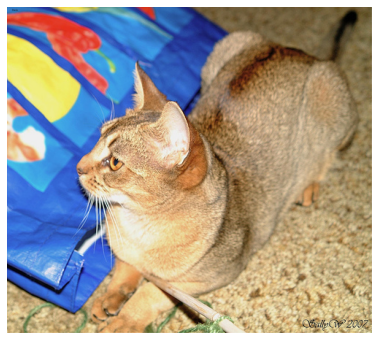

In [6]:
plt.figure(figsize=(9, 6))
plt.axis("off")
plt.imshow(load_img(input_img_paths[9]))
plt.show()

In [7]:
def display_target(target_array):
    normalized_array = (target_array.astype("uint8") - 1) * 127
    plt.figure(figsize=(9, 6))
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0])
    plt.show()

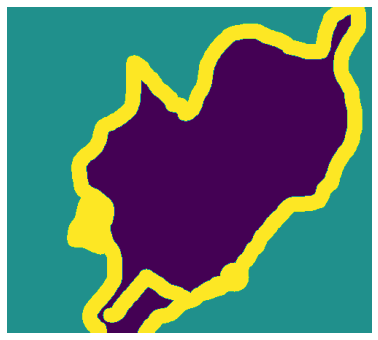

In [8]:
img = img_to_array(load_img(target_paths[9], color_mode="grayscale"))
display_target(img)

The target mask pixels can take 3 values:
- 1(foreground)
- 2(background)
- 3(contour)

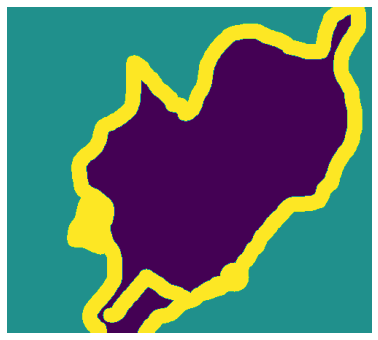

In [9]:
# Another way to display the targets

plt.figure(figsize=(9, 6))
plt.axis("off")
plt.imshow(load_img(target_paths[9], grayscale=True))
plt.show()

#### Data Preparation
- Load the data into numpy arrays
- Split the data into training and validation sets

In [10]:
img_size = (200, 200)
num_imgs = len(input_img_paths)

# shuffling the data using the same seed so the order of images and masks remain the same

random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(load_img(path, target_size=img_size, grayscale=True))
    img = img.astype("uint8") - 1 # so the targets become 0, 1 and 2
    return img

# load input images and targets as numpy arrays

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")

targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")

for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

# splitting the data into training and validation

num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

### Model Definition

In [11]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Rescaling(1./255) (inputs)
    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same") (x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same") (x)
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same") (x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same") (x)
    x = layers.Conv2D(256, 3, strides=2, activation="relu", padding="same") (x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same") (x)

    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same") (x)
    x = layers.Conv2DTranspose(256, 3, strides=2, activation="relu", padding="same") (x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same") (x)
    x = layers.Conv2DTranspose(128, 3, strides=2, activation="relu", padding="same") (x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same") (x)
    x = layers.Conv2DTranspose(64, 3, strides=2, activation="relu", padding="same") (x)

    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same") (x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [12]:
model = get_model(img_size, 3)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 256)       295168

In [13]:
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy")

callbacks = [
             keras.callbacks.ModelCheckpoint("oxford_segmentation.keras",
                                             save_best_only=True)
]

In [14]:
history = model.fit(train_input_imgs,
                    train_targets,
                    batch_size=64,
                    epochs=50,
                    validation_data=(val_input_imgs, val_targets),
                    callbacks=callbacks)

Epoch 1/50
100/100 [==============================] - 153s 1s/step - loss: 1.1287 - val_loss: 0.9823
Epoch 2/50
100/100 [==============================] - 124s 1s/step - loss: 0.9367 - val_loss: 0.8588
Epoch 3/50
100/100 [==============================] - 124s 1s/step - loss: 0.8581 - val_loss: 0.7816
Epoch 4/50
100/100 [==============================] - 124s 1s/step - loss: 0.8010 - val_loss: 0.8342
Epoch 5/50
100/100 [==============================] - 125s 1s/step - loss: 0.7648 - val_loss: 0.7420
Epoch 6/50
100/100 [==============================] - 125s 1s/step - loss: 0.7069 - val_loss: 0.7731
Epoch 7/50
100/100 [==============================] - 125s 1s/step - loss: 0.6595 - val_loss: 0.6119
Epoch 8/50
100/100 [==============================] - 125s 1s/step - loss: 0.6486 - val_loss: 0.6672
Epoch 9/50
100/100 [==============================] - 125s 1s/step - loss: 0.6082 - val_loss: 0.5471
Epoch 10/50
100/100 [==============================] - 125s 1s/step - loss: 0.5875 - val_lo

#### Predicting segmentation mask for an image

In [18]:
from tensorflow.keras.utils import array_to_img

In [20]:
model = keras.models.load_model("oxford_segmentation.keras")

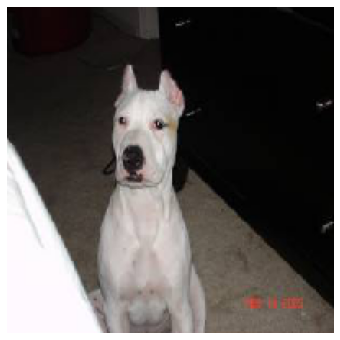

In [24]:
i = 4
test_image = val_input_imgs[i]
plt.figure(figsize=(9, 6))
plt.axis("off")
plt.imshow(array_to_img(test_image))
plt.show()

In [25]:
mask = model.predict(np.expand_dims(test_image, 0))[0]

In [37]:
def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    plt.figure(figsize=(7, 5))
    plt.axis("off")
    plt.imshow(mask)
    plt.show()

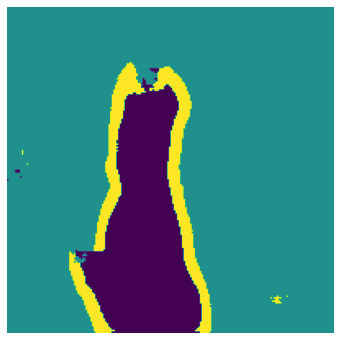

In [33]:
display_mask(mask)

#### Another prediction

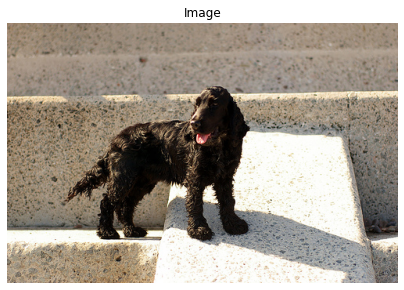

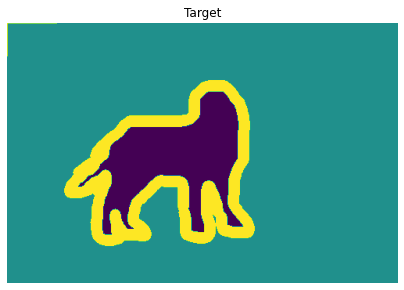

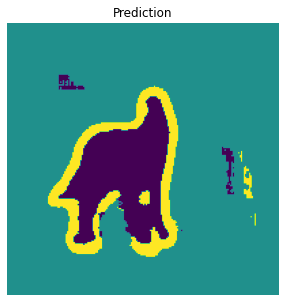

In [38]:
i = 9
pred = model.predict(np.expand_dims(train_input_imgs[i], 0))[0]
mask = np.argmax(pred, axis=-1)
plt.figure(figsize=(7, 5))
plt.axis("off")
plt.imshow(load_img(input_img_paths[i]))
plt.title("Image")
plt.figure(figsize=(7, 5))
plt.axis("off")
plt.imshow(load_img(target_paths[i], grayscale=True))
plt.title("Target")
plt.figure(figsize=(7, 5))
plt.axis("off")
plt.imshow(mask)
plt.title("Prediction")
plt.show()